In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy matplotlib svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision # Import torchvision here


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(grid_im.numpy().astype(np.uint8)) # Use .numpy() for conversion
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading training dataset

In [ ]:
!wget -q https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy -O cat.npy

shape: (123202, 784)


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

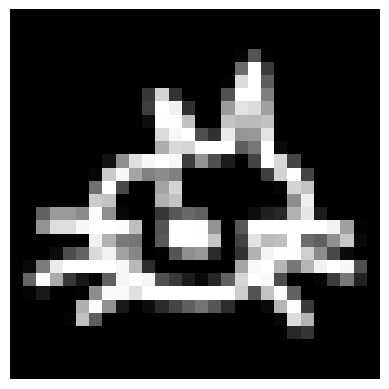

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('cat.npy')  # shape (N, 784)
print('shape:', data.shape)
img = data[0].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')

In [ ]:
from datasets import Dataset

# Assuming 'data' is your numpy array with shape (N, 784)
# We need to reshape it to (N, 28, 28) and potentially add a channel dimension if needed
# For grayscale images, the shape would be (N, 28, 28, 1)
# If your data is already in the desired image format (H, W, C), you might not need the reshape
reshaped_data = data.reshape(-1, 28, 28)

# Create a dictionary where keys are column names and values are the data arrays
# You can add other columns here if you have labels or other metadata
data_dict = {
    "image": reshaped_data
}

# Create the Dataset
dataset = Dataset.from_dict(data_dict)

print(dataset)

Dataset({
    features: ['image'],
    num_rows: 123202
})


In [ ]:
# Split the dataset into training and testing sets
dataset = dataset.train_test_split(test_size=0.1)

# Access the splits
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print("Training dataset:", train_dataset)
print("Testing dataset:", test_dataset)

Training dataset: Dataset({
    features: ['image'],
    num_rows: 110881
})
Testing dataset: Dataset({
    features: ['image'],
    num_rows: 12321
})


In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch # Import torch here
import numpy as np # Import numpy here


# dataset_train = dataset["train"] # This line is no longer needed as we use train_dataset

# dataset = load_dataset("quickdraw", 'full', split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    # Convert numpy arrays to PIL Images before processing and then stack into a single tensor
    # Explicitly convert each image to a numpy array and ensure it has 3 channels
    images = []
    for image_data in examples["image"]:
        # Ensure the image data is a numpy array and has the correct shape and dtype
        img_array = np.array(image_data, dtype=np.uint8) # Explicitly convert to uint8
        if img_array.ndim == 2: # If grayscale (H, W)
            img_array = np.stack([img_array] * 3, axis=-1) # Convert to (H, W, 3)
        elif img_array.ndim == 3 and img_array.shape[-1] == 1: # If grayscale with channel dim (H, W, 1)
             img_array = np.repeat(img_array, 3, axis=-1) # Convert to (H, W, 3)

        # Convert to PIL Image and then to RGB
        pil_image = Image.fromarray(img_array).convert("RGB")
        images.append(preprocess(pil_image))

    # Stack the list of tensors into a single tensor
    return {"images": torch.stack(images)}

# Apply the transform to the training dataset split
train_dataset.set_transform(transform)


# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

X shape: torch.Size([8, 3, 32, 32])


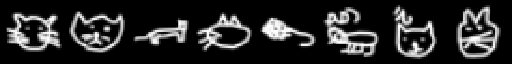

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

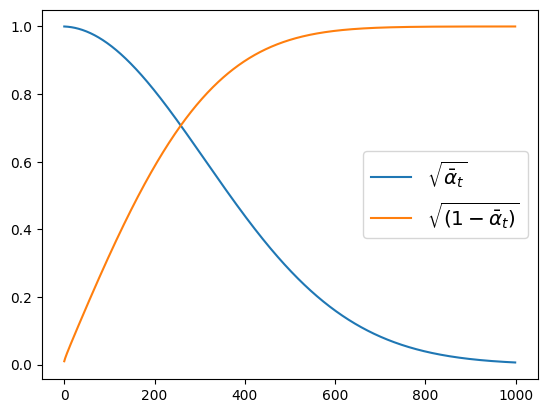

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

In [ ]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Noisy X shape torch.Size([8, 3, 32, 32])


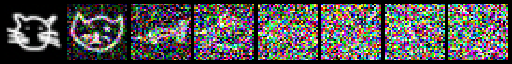

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
checkpoint_dir = "checkpoints"
import os
os.makedirs(checkpoint_dir, exist_ok=True)

# Check if there's a checkpoint to resume from
latest_checkpoint = None
if os.listdir(checkpoint_dir):
    latest_checkpoint = max([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir)], key=os.path.getctime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
else:
    start_epoch = 0


for epoch in range(start_epoch, 30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

Epoch:5, loss: 0.023022965857500088
Checkpoint saved to checkpoints/checkpoint_epoch_5.pt
Epoch:10, loss: 0.021043366838012275
Checkpoint saved to checkpoints/checkpoint_epoch_10.pt


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()